## Predict price at next period with LSTM and Keras as a Classification


In [1]:
import sys
import time
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

import mysql.connector
from mysql.connector import errorcode

import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

print(tf.__version__)
print(sys.version)

# https://mapr.com/blog/deep-learning-tensorflow/


/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


1.0.0
3.5.4 |Anaconda custom (x86_64)| (default, Sep 21 2017, 18:03:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

from ittutils import ittconnection, get_resampled, get_raw_price, get_raw_volume

/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Get timeseries from Staging DB (both minute and hours)


In [3]:
db_connection = ittconnection('prodcopy')

transaction_coin = 'ETH'
counter_coin = 0
resample_period = 60

In [4]:
raw_price_ts = get_raw_price(db_connection, transaction_coin, counter_coin)
raw_volume_ts = get_raw_volume(db_connection, transaction_coin, counter_coin)

raw_price_ts["volume"] = raw_volume_ts

In [5]:
raw_price_ts.tail(3)

,price,volume
timestamp,,
2018-03-01 15:57:42.772320,8058902,1471.485608
2018-03-01 15:58:44.667620,8046897,1471.783897
2018-03-01 15:59:46.785290,8045101,1476.187363


In [6]:
price_ts = raw_price_ts  # remove gaps
price_ts[pd.isnull(price_ts["price"])] = None

# resample (for smoothing) and normalize (for learning)
price_ts = price_ts.resample(rule='30min').mean()

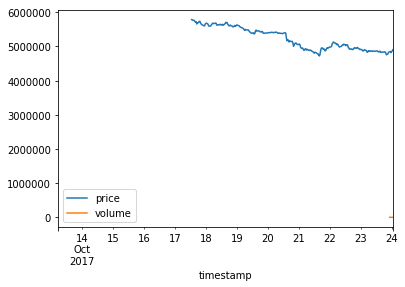

In [7]:
cutoff=520
price_ts.head(cutoff).plot()

In [8]:
# cut empty ts from the beginning
price_ts = price_ts.tail(len(price_ts)-cutoff)
price_ts = price_ts.interpolate() #fillna(method='ffill')

# normalize to 0 - 1
price_ts =  ((price_ts - price_ts.mean()) / (price_ts.max() - price_ts.min()) )
price_ts = price_ts + abs(price_ts.min(axis=0))


In [9]:
price_ts.min(axis=0)

price     0.0
volume    0.0
dtype: float64

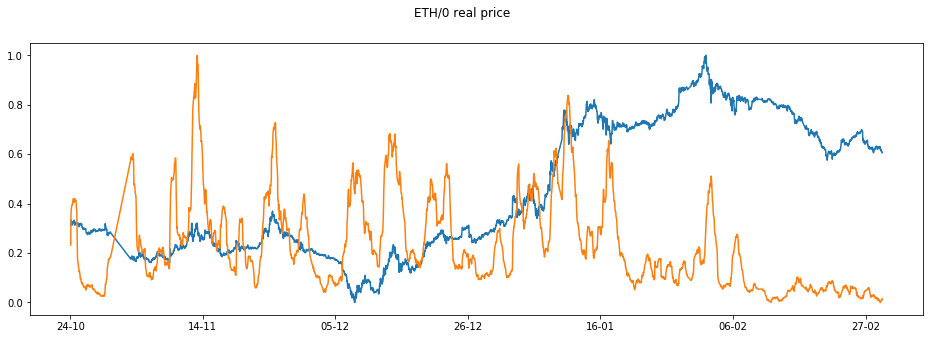

In [10]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.suptitle("%s/%d real price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(price_ts)
plt.show()

In [11]:
#print(resampl_ts.shape)
print(price_ts.shape)

(6173, 2)


## Helper functions to convert ts into dataset

In [99]:
# CLASSIFICATION: dataset for univariate classification: labels are not future price but 
def classification_dataset_from_ts(data_df, win_size, stride, forward_time_points, delta):
    n = len(data_df)
    num_examples = int((n-win_size)/stride)
    predictors = 2  # make prediction based on multivatiate ts, price and volume
    
    # (4968, 96, 1)
    data_set = np.zeros([win_size,num_examples])
    labels = np.zeros([3,num_examples])   # 3 classes!!! 0-same/ 1-up / 2 -down  with 5%
    
    data_set = np.zeros([num_examples, win_size, predictors])
    labels = np.zeros([num_examples,3])  # 3 classes!!! 0-same/ 1-up / 2 -down  with 5%

    for ex in range(0,num_examples):
        one_example_df = data_df[ex:ex+win_size]['price']
        one_example_vector = one_example_df.values.reshape([-1,1])

        
        # get future prices
        future_prices_df = data_df[ex+win_size : ex+win_size+forward_time_points]['price']
        #print("future prices")
        #print(future_prices_df)
        previous_price = one_example_df.tail(1).values
        max_pr = future_prices_df.max()
        min_pr = future_prices_df.min()
        mean_pr = future_prices_df.mean()
        
        #print("Previous prices")
        #print(previous_price)
        
        # label_1 = 1 if last price hits current+5% in the following forward_time_points
        
        price_change = abs(previous_price - mean_pr)/previous_price
        
        label_0, label_1, label_2 = (0,0,0)
        
        if (price_change < delta):
            label_0 = int(1)   # the change is less then delte percents
        elif (previous_price - mean_pr) > 0:
            label_2 = int(1)   # decline    
        elif (previous_price - mean_pr) < 0:
            label_1 = int(1)    # growing
        
        
        '''
        if max_pr > (previous_price * delta):
            label_1 = int(1)
        elif min_pr < (previous_price * (1-delta)):
            label_2 = int(1)
        else:
            label_0 = int(1)
        '''    
        
        
        data_set[:,ex] = one_example_vector[:,0]
        #print(data_set.shape)
        labels[0,ex] = label_0
        labels[1,ex] = label_1
        labels[2,ex] = label_2
        #print("Label")
        #print(labels[:,ex])

        
        #print("p="+str(previous_price)+ " / max_pr=" +str(max_pr) + "/ min pr="+str(min_pr)+" labels="+str(labels[:,ex]) )
        
    return data_set, labels



# REGRESSION: dataset for regression: split one continues timeseries inro many subsets by striding
def regression_dataset_from_ts(data_df, win_size, stride):
    n = len(data_df)
    num_examples = int((n-win_size)/stride)
    
    # (4968, 96, 1)
    predictors = 2  # make prediction based on multivatiate ts, price and volume
    data_set = np.zeros([num_examples, win_size, predictors])
    labels = np.zeros([num_examples,1])

    for ex in range(0,num_examples):
        one_example_0 = data_df[ex:ex+win_size]['price'].values.reshape([-1,1])
        one_example_1 = data_df[ex:ex+win_size]['volume'].values.reshape([-1,1])
        #print(one_example.shape)
        label = data_df[ex+win_size:ex+win_size+1]['price'].values.reshape([-1,1])
        #print(label.shape)
        
        data_set[ex,:,0] = one_example_0[:,0]
        data_set[ex,:,1] = one_example_1[:,0]
        #print(data_set.shape)
        labels[ex,:] = label
    return data_set, labels


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) /  predictions.shape[0])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 


# REGRESSION

## Create a dataset by converting ts into matrix (X,Y)

In [100]:
train_num = int(len(price_ts) * 0.8)
test_num = len(price_ts) - train_num
             
ts_train = price_ts.head(train_num)
ts_test = price_ts.tail(test_num)

win_size = 96

# convert linear ts to number of training examples
X_train, Y_train = regression_dataset_from_ts(data_df=ts_train, win_size=win_size, stride=1)
X_test, Y_test = regression_dataset_from_ts(data_df=ts_test, win_size=win_size, stride=1)



In [103]:
Y_train.shape

(4720, 1)

In [104]:

n_time_features = X_train.shape[1]
classes = Y_train.shape[1]
m_test = X_test.shape[0]
m_train = X_train.shape[0]

In [105]:
X_train = X_train.astype(dtype=np.float32)
X_test = X_test.astype(dtype=np.float32)


print(X_train.shape)
print(Y_train.shape)
#print("Y train first  = ")
#print( str(Y_train[0:3,]))

print(X_test.shape)
print(Y_test.shape)

print(" m_train %d, m_test %d, n_features %d, classes %d" % (m_train, m_test,n_features,classes ))
  

(4720, 96, 2)
(4720, 1)
(1108, 96, 2)
(1108, 1)
 m_train 4720, m_test 1108, n_features 96, classes 1


(4968, 96, 1)
(4968, 1)
(1170, 96, 1)


# KERAS
The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions 

(N, W, F) where
- N is the number of training sequences, 
- W is the sequence length and 
- F is the number of features of each sequence

network structure of [1, 50, 100, 1] where 
- 1 input layer (consisting of a sequence of size 50) which feeds into an LSTM layer with 50 neurons, 
- that in turn feeds into another LSTM layer with 100 neurons 
- which then feeds into a fully connected normal layer of 1 neuron with a linear activation function which will be used to give the prediction of the next time step.

<img src="images/rnn.jpeg" style="width:600;height:400px;">

In [112]:
layers = [1, win_size, 100, 1]

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.1))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [113]:

layers = [2, win_size, 140, 1]

epochs  = 5

model = build_model(layers)

model.fit(
    X_train,
    Y_train,
    batch_size=32,
    nb_epoch=epochs,
    validation_split=0.05)



/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 2), return_sequences=True, units=96)`
  if __name__ == '__main__':
/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


> Compilation Time :  0.08132004737854004
Train on 4484 samples, validate on 236 samples
Epoch 1/5
4484/4484 [==============================] - 92s 20ms/step - loss: 0.0048 - val_loss: 0.0166
Epoch 2/5
4484/4484 [==============================] - 88s 20ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 3/5
4484/4484 [==============================] - 86s 19ms/step - loss: 0.0015 - val_loss: 4.9410e-04
Epoch 4/5
4484/4484 [==============================] - 87s 19ms/step - loss: 0.0013 - val_loss: 7.8329e-05
Epoch 5/5
4484/4484 [==============================] - 84s 19ms/step - loss: 0.0011 - val_loss: 7.8304e-05


In [114]:
y_predicted_train = predict_point_by_point(model, X_train)
predicted = predict_point_by_point(model, X_test)

#predicted = lstm.predict_sequence_full(model, X_test, seq_len)
#predicted = lstm.predict_point_by_point(model, X_test) 
#plot_results_multiple(predictions, y_test, 50)

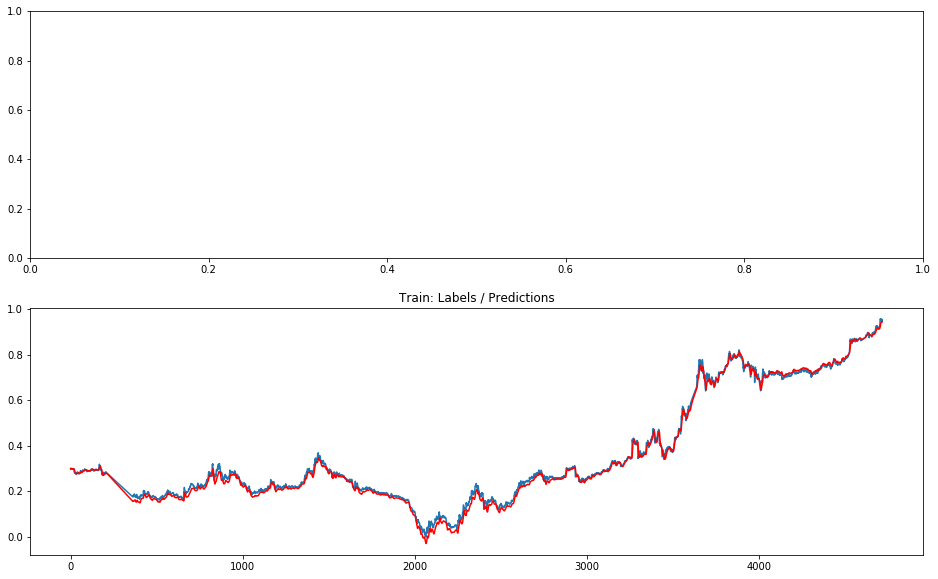

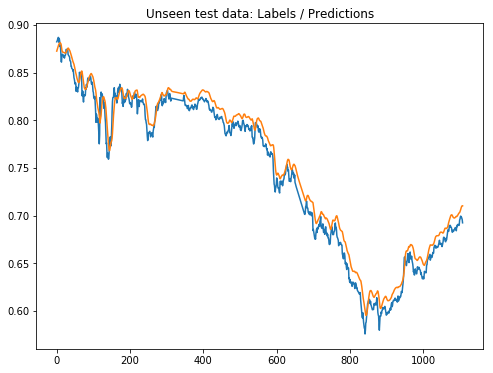

In [115]:

fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(16,10))

ax2.set_title("Train: Labels / Predictions")    
ax2.plot(Y_train)
ax2.plot(y_predicted_train, color="red")
plt.show()


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax1.set_title("Unseen test data: Labels / Predictions")
ax1.plot(Y_test)
ax1.plot(predicted)
plt.show()

In [80]:
str(model)

'<keras.models.Sequential object at 0x1c31aba5c0>'